In [1]:
import sys
from pyprojroot import here as project_root

sys.path.insert(0, str(project_root()))

from fs_mol.data.dkt import get_dkt_batcher
from fs_mol.utils.torch_utils import torchify

from bayes_opt.bo_utils import load_antibiotics_dataset, run_gp_ei_bo, min_so_far, task_to_batches, PARModelFeatureExtractor
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RDKit WARNING: [11:39:05] Enabling RDKit 2019.09.3 jupyter extensions
[11:39:05] Enabling RDKit 2019.09.3 jupyter extensions
/scratches/gauss/wc337/miniconda3/envs/par2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratches/gauss/wc337/miniconda3/envs/par2/lib/python3.8/site-packages/learn2learn/vision/benchmarks/omniglot_benchmark.py:7: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from PIL.Image import LANCZOS


In [2]:
task = load_antibiotics_dataset("antibiotics-dataset.xlsx", "../../fs_mol/preprocessing/utils/helper_files/")

/scratches/gauss/wc337/miniconda3/envs/par2/lib/python3.8/site-packages/rdkit/Chem/EState/EState.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Is = numpy.zeros(nAtoms, numpy.float)
/scratches/gauss/wc337/miniconda3/envs/par2/lib/python3.8/site-packages/rdkit/Chem/Graphs.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = num

In [3]:
batcher = get_dkt_batcher(max_num_graphs=100)
dkt_batches = torchify(
    task_to_batches(task, batcher), 
    device=device
)

In [4]:
model_weights_file = "../../outputs/PAR/best_validation.pt"

par_model = PARModelFeatureExtractor.build_from_model_file(
    model_weights_file,
    device=device
).to(device)

par_model.eval()

PARModelFeatureExtractor(
  (graph_feature_extractor): GraphFeatureExtractor(
    (init_node_proj): Linear(in_features=32, out_features=128, bias=False)
    (gnn): GNN(
      (gnn_blocks): ModuleList(
        (0): GNNBlock(
          (mp_layers): ModuleList(
            (0): RelationalMultiAggrMP(
              (message_fns): ModuleList(
                (0): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
                (1): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
                (2): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
              )
            )
            (1): RelationalMultiAggrMP(
              (message_fns): ModuleList(
   

In [5]:
representations = []

for features in dkt_batches:
    representation = par_model.get_representation(features)
    representations.append(representation)
    
del par_model

In [6]:
dataset = task.samples

x_all = torch.cat(representations, dim=0)
y_all = torch.FloatTensor([float(x.numeric_label) for x in dataset]).to(device)

In [7]:
num_init_points = 16
query_batch_size = 1
num_bo_iters = 20
kernel_type = "matern"
init_from = 1600
noise_init = 0.01
noise_prior = True

num_repeats = 20

bo_records = []

In [8]:
for repeat in tqdm(range(num_repeats)):
    bo_record = run_gp_ei_bo(dataset, x_all, y_all, num_init_points, query_batch_size, num_bo_iters, kernel_type, device, init_from, noise_init, noise_prior)
    bo_records.append(min_so_far(bo_record))

  0%|                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]/scratches/gauss/wc337/miniconda3/envs/par2/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

(0.0, 1.5)

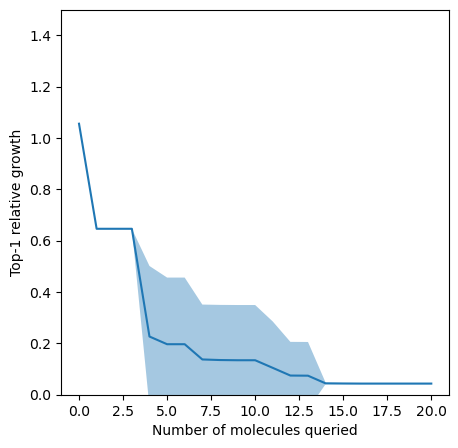

In [9]:
x_axis = np.arange(query_batch_size*num_bo_iters+1)

bo_records = np.array([[y_all[i].item() for i in bo_record] for bo_record in bo_records])
bo_records_mean = bo_records.mean(axis=0)
bo_records_std = bo_records.std(axis=0)

plt.figure(figsize=(5,5))

plt.plot(x_axis, bo_records_mean)
plt.fill_between(x_axis, bo_records_mean-bo_records_std, bo_records_mean+bo_records_std, alpha=0.4)

plt.xlabel("Number of molecules queried")
plt.ylabel("Top-1 relative growth")
plt.ylim(0, 1.5)

In [10]:
import pickle

with open("outputs/par_bo_records.pkl", "wb") as output_file:
    pickle.dump(bo_records, output_file)